/tmp/ipykernel_72494/3770673397.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Processing 1 of 1460 timesteps
Processing 2 of 1460 timesteps
Processing 3 of 1460 timesteps
Processing 4 of 1460 timesteps
Processing 5 of 1460 timesteps
Processing 6 of 1460 timesteps
Processing 7 of 1460 timesteps
Processing 8 of 1460 timesteps
Processing 9 of 1460 timesteps
Processing 10 of 1460 timesteps
Processing 11 of 1460 timesteps
Processing 12 of 1460 timesteps
Processing 13 of 1460 timesteps
Processing 14 of 1460 timesteps
Processing 15 of 1460 timesteps
Processing 16 of 1460 timesteps
Processing 17 of 1460 timesteps
Processing 18 of 1460 timesteps
Processing 19 of 1460 timesteps
Processing 20 of 1460 timesteps
Processing 21 of 1460 timesteps
Processing 22 of 1460 timesteps
Processing 23 of 1460 timesteps
Processing 24 of 1460 timesteps
Processing 25 of 1460 timesteps
Processing 26 of 1460 timesteps
Processing 27 of 1460 timesteps
Processing 28 of 1460 timesteps
Processing 29 of 1460 timesteps
Processing 30 of 1460 timesteps
Processing 31 of 1460 timesteps
Processing 32 of 

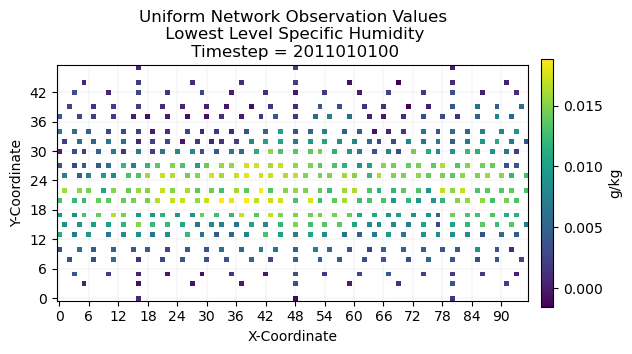

[961.06416016 961.08770142 960.30631714 958.57626648 959.81113892
 959.57363892 960.16025696 958.35975647 960.3721283  958.88433228
 958.24384766 958.89650879 959.96282349 960.19139404 959.68809814
 959.72236633 959.21060486 960.66877136 962.40508423 958.65471802
 960.45295715 959.65133667 961.50500793 959.93580322 963.11329346
 962.64942627 960.99162292 959.29091187 961.10184937 962.30778809
 960.89165955 960.46559753 959.68200989 961.30519714 959.27763367
 960.63624268 961.75387268 960.81999207 962.80006714 962.11192017
 962.07782593 961.87615967 962.60570679 959.95899658 963.30214539
 963.26416626 961.78564758 959.49982605 960.69573364 962.34501343]
[292.59643555 290.7663269  291.9069519  291.28338623 289.9631958
 290.39538574 290.92901611 291.64743042 289.63696289 290.85107422
 290.69073486 290.72943115 290.49972534 290.45895386 291.69866943
 291.05255127 291.35089111 291.32995605 291.20541382 291.86199951
 290.91363525 288.92175293 290.62527466 290.93685913 290.03961182
 293.22482

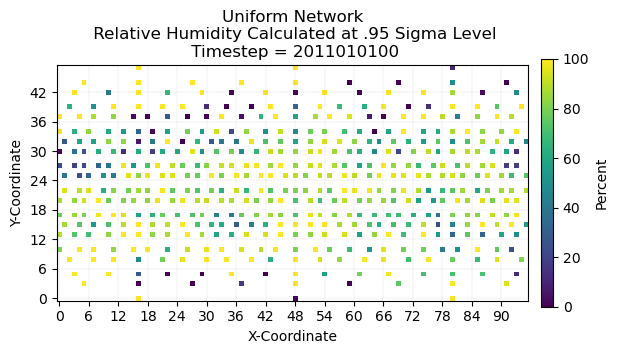

In [1]:
# all script for run in another script
#packages
from glob import glob
from os import chdir
from sys import argv
import numpy as np
import matplotlib.pyplot as plt
# import copy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Open binary obs files in the obs_netcdftest file

# Change to relevant experiment directory
# chdir(f'/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/obs_netcdftest/')

# Glob observation files
files = sorted(glob('/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/obs_netcdftest/*.dat'))

# Define model state dimensions as with files (representing 6 hourly data)
ntime, nlat, nlon, nlev = len(files), 48, 96, 8

# Define fields
fields = [
    {'id': 14593, 'name': 'Surface Pressure [Pa]', 'short': 'ps'},
    {'id': 2819, 'name': 'U-wind [m/s]', 'short': 'u'},
    {'id': 2820, 'name': 'V-wind [m/s]', 'short': 'v'},
    {'id': 3073, 'name': 'Temperature [K]', 'short': 't'},
    {'id': 3330, 'name': 'Specific Humidity [kg/kg]', 'short': 'q'}
]

# Get Gaussian latitudes from GrADS control file
with open('/skydata2/dylanelliott/letkf-hybrid-speedy/common/t30.ctl') as f:
    content = f.readlines()[5]
    lats = [np.float32(lat) for lat in content.split()[3:]]
    lats_py = [float(lat) for lat in content.split()[3:]]

# Define longitudes
lons = np.arange(0, 360, 3.75)

# Define sigma coordinates
sigmas = [0.95, 0.835, 0.685, 0.51, 0.34, 0.2, 0.095, 0.025]

# LOOP THROUGH ALL FILES in obs_netcdftest


# Define model state dimensions
ntime, nlat, nlon, nlev = len(files), 48, 96, 8

# Define fields
fields = [
    {'id': 14593, 'name': 'Surface Pressure [Pa]', 'short': 'ps'},
    {'id': 2819, 'name': 'U-wind [m/s]', 'short': 'u'},
    {'id': 2820, 'name': 'V-wind [m/s]', 'short': 'v'},
    {'id': 3073, 'name': 'Temperature [K]', 'short': 't'},
    {'id': 3330, 'name': 'Specific Humidity [kg/kg]', 'short': 'q'}
]


# define empty array to save each timestep's array in there for below loop
obs_all_timesteps = []
ps_obs_all_timesteps = []

# Loop over all observation files (each one represents one set of 6 hourly observations)
for t, file in enumerate(files):
#     print(file)
    print(f'Processing {t+1} of {ntime} timesteps')
    # Read data from file
    data = np.fromfile(file, dtype=np.float32).byteswap()
#     print(data)
    # Select obs network to read in file
    sparse_network = 12064
    uniform_network = 7250*2
    
    data = np.reshape(data, (uniform_network,8)) 

    # Delete first and last columns - these are used by FORTRAN to give the number of bytes
    # in between, i.e. the length of a row
    data = np.delete(data, [0,7], axis=1)
    
    # First process surface pressure
    ps_obs = data[data[:,0] == fields[0]['id']]
    
    # make array to store the ps obs
    ps_obs_full = np.zeros((48,96))
    
    
    for ob in ps_obs:
        lat_i = np.where(lats == ob[2])[0][0]
        lon_i = np.where(lons == ob[1])[0][0]
        # Convert pressure from hPa to Pa
#         print(lat_i, lon_i, ob[4] ) # hPa 
        ps_obs_full[lat_i, lon_i] =  ob[4] * 100.0 # Pa
#         cubes[0].data[t, lat_i, lon_i] = 100.0*ob[4]

    ps_obs_all_timesteps.append(ps_obs_full)
    
    # make array to store all 3-d obs
    obs_full = np.zeros((4, 48,96,8))
    
    # Now process the other fields
    for i, field in enumerate(fields[1:],1):
        # Get all observations of this field
        obs = data[data[:,0] == field['id']]
        counter = 0 
        for ob in obs:
            lat_i = np.where(lats == ob[2])[0][0]
            lon_i = np.where(lons == ob[1])[0][0]
            
            if field['id'] == 3330:  #account for specific humidity obs being only on the first 4 levels
               obs_full[i-1,lat_i,lon_i,counter%4] = ob[4]
            else:
               obs_full[i-1,lat_i,lon_i,counter%8] = ob[4]
#             print(field, lat_i, lon_i, 100.0*ob[3], ob[4], counter%8)
            counter = counter + 1
    
    # save newly created local array called obs_full to new array containing length of 1460
    # Append the obs_full array of each timestep to the list
    obs_all_timesteps.append(obs_full)
    
    
#             sigma = np.around(100.0*ob[3]/nature_ps.data[t, lat_i, lon_i], decimals=3)
#             lev_i = np.where(sigmas == sigma)[0][0]
    if t + 1 == 50:
            break
# print(obs_all_timesteps[0][1,:,:,7])
# print(len(obs_all_timesteps))
# print(np.shape(obs_all_timesteps))

print('correct for 0s in array by adding nans') 
# Iterate through each element of obs_all_timesteps
for i in range(len(obs_all_timesteps)):
    obs_all_timesteps[i][obs_all_timesteps[i]==0] = np.nan 
    ps_obs_all_timesteps[i][ps_obs_all_timesteps[i]==0] = np.nan
# print(len(obs_all_timesteps))
print(np.shape(obs_all_timesteps))
# make numpy array 
type(obs_all_timesteps)
ps_obs_all_timesteps_array = np.array(ps_obs_all_timesteps)
obs_all_timesteps_array = np.array(obs_all_timesteps)
obs_all_timesteps_array[0]
print('Done.')


obs_all_timesteps[0][1,:,:,7]
print(len(obs_all_timesteps))
print(np.shape(obs_all_timesteps))

print('correct for 0s in array by adding nans') 
# Iterate through each element of obs_all_timesteps
for i in range(len(obs_all_timesteps)):
    obs_all_timesteps[i][obs_all_timesteps[i]==0] = np.nan        
print(len(obs_all_timesteps))
print(np.shape(obs_all_timesteps))
print('Bingo.')
obs_all_timesteps_array = np.array(obs_all_timesteps)
# plot correct side up with grid so I can select our boys (specific gridpoints by eyeing the graph)

# dimension 1 is index 0 is wind, 1 is wind, 2 is temp, 3 is humid 
# pressure surf is defined in another array
plt.title('Uniform Network Observation Values\n Lowest Level Specific Humidity\n Timestep = 2011010100')
plt.imshow(obs_all_timesteps[0][3,:,:,0],origin='lower') # origin lower fixed it
plt.colorbar(orientation='vertical', fraction=0.025, pad=0.025, label = 'g/kg')
plt.grid(color='grey', linestyle='--', linewidth=.1)
plt.xlabel('X-Coordinate')
plt.xticks(range(0,96,6))
plt.yticks(range(0,48,6))
plt.ylabel('Y-Coordinate')
plt.show()


from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units

# EXAMPLE GIVEN
# relative_humidity_from_specific_humidity(1013.25 * units.hPa,
#                                          30 * units.degC, 18/1000).to('percent')
# <Quantity(68.3229304, 'percent')>


# get data, ps, T, q for RH
# So you need to do surface_pressure * sigma_level
ps_west_africa_all = (ps_obs_all_timesteps_array[:,20,0] / 100) * 0.95 # sigma level
print(ps_west_africa_all)
t_west_africa_all = obs_all_timesteps_array[:,2,20,0,0] # Kelvin
print(t_west_africa_all)
q_west_africa_all = obs_all_timesteps_array[:,3,20,0,0] # 3 = specific humidity in kg/kg
print(q_west_africa_all)
RH_at_west_africa_ocean = relative_humidity_from_specific_humidity(ps_west_africa_all * units.hPa, \
                                         (t_west_africa_all - 273.15) * units.degC, q_west_africa_all ).to('percent')

RH_at_west_africa_ocean




# Calculate across all lat/lons

# get data, ps, T, q for RH
# So you need to do surface_pressure * sigma_level
ps_all_lat_lons = (ps_obs_all_timesteps_array[:,:,:] / 100) * 0.95 # sigma level
print(ps_all_lat_lons)
t_all_lat_lons = obs_all_timesteps_array[:,2,:,:,0] # Kelvin
print(t_all_lat_lons)
q_all_lat_lons = obs_all_timesteps_array[:,3,:,:,0] # 3 = specific humidity in kg/kg
print(q_all_lat_lons)
RH_at_all_lat_lons = relative_humidity_from_specific_humidity(ps_all_lat_lons * units.hPa, \
                                         (t_all_lat_lons - 273.15) * units.degC, q_all_lat_lons ).to('percent')
print(RH_at_all_lat_lons)

print(RH_at_all_lat_lons[0,20,0])

RH_at_all_lat_lons_array = np.array(RH_at_all_lat_lons)
# RH_at_all_lat_lons_array = [float(x) for x in RH_at_all_lat_lons_array]
RH_at_all_lat_lons_array.astype(float)
print(RH_at_all_lat_lons_array[0,20,0])

# plt.imshow()

# dimension 1 is index 0 is wind, 1 is wind, 2 is temp, 3 is humid 
# pressure surf is defined in another array
plt.title('Uniform Network\n Relative Humidity Calculated at .95 Sigma Level\n Timestep = 2011010100')
plt.imshow(RH_at_all_lat_lons_array[0,:,:],origin='lower', vmin=0, vmax=100) # origin lower fixed it
plt.colorbar(orientation='vertical', fraction=0.025, pad=0.025, label = 'Percent')
plt.grid(color='grey', linestyle='--', linewidth=.1)
plt.xlabel('X-Coordinate')
plt.xticks(range(0,96,6))
plt.yticks(range(0,48,6))
plt.ylabel('Y-Coordinate')
plt.show()


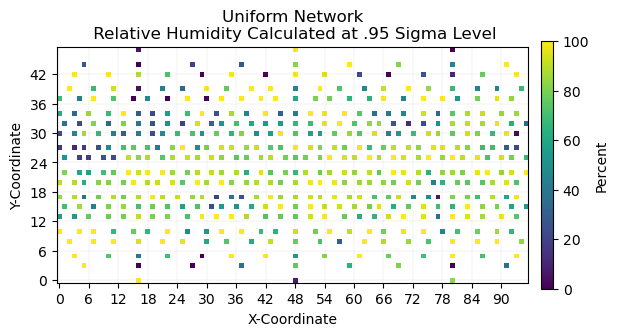

In [4]:

plt.title('Uniform Network\n Relative Humidity Calculated at .95 Sigma Level')
plt.imshow(RH_at_all_lat_lons_array[34,:,:],origin='lower', vmin=0, vmax=100) # origin lower fixed it
plt.colorbar(orientation='vertical', fraction=0.025, pad=0.025, label = 'Percent')
plt.grid(color='grey', linestyle='--', linewidth=.1)
plt.xlabel('X-Coordinate')
plt.xticks(range(0,96,6))
plt.yticks(range(0,48,6))
plt.ylabel('Y-Coordinate')
plt.show()


In [37]:
# IMPORT
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit

from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units

In [38]:
letkf_speedy_ds

<xarray.Dataset>
Dimensions:  (time: 2437, lon: 96, lat: 48, lev: 8)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-01 2011-01-01T06:00:00 ... 2012-09-01
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lev      (lev) float64 0.95 0.835 0.685 0.51 0.34 0.2 0.095 0.025
Data variables:
    u        (time, lev, lat, lon) float32 ...
    v        (time, lev, lat, lon) float32 ...
    t        (time, lev, lat, lon) float32 ...
    q        (time, lev, lat, lon) float32 ...
    ps       (time, lat, lon) float32 ...
    rain     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Jun 29 13:08:06 2023: cdo -f nc import_binary t30.ctl m...
    CDO:          Climate Data Operators version 2.0.0 (https://mpimet.mpg.de...

In [55]:
# Lets do a RH calculation on a random point on letkf-speedy to see if RH
# package even works

# load LETKF-SPEEDY DATA 

speedy_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'

letkf_speedy_ds = xr.open_dataset(speedy_file)

# get ds, q, t, ps to use for calculation
var_list = ['q','t','ps']

level = .95
startdate = datetime(2011,1,1,0)
enddate = datetime(2011,12,31,18)
time_slice = slice(startdate,enddate)


letkf_speedy_q = letkf_speedy_ds['q'].sel(lev=level,time=time_slice)
letkf_speedy_t = letkf_speedy_ds['t'].sel(lev=level,time=time_slice)
letkf_speedy_ps= (letkf_speedy_ds['ps'].sel(time=time_slice) / 100 * 0.95)

# lets calculate at every point
length = (len(letkf_speedy_q['time']))
ygrid = len(letkf_speedy_q['lat'])
xgrid = len(letkf_speedy_q['lon'])

letkf_speedy_RH = np.zeros((length,ygrid,xgrid))

for t in range(length):
    letkf_speedy_RH[t,:,:] = relative_humidity_from_specific_humidity(letkf_speedy_ps[t,:,:].values * units.hPa, \
                                         (letkf_speedy_t[t,:,:].values - 273.15) * units.degC, letkf_speedy_q[t,:,:].values ).to('percent')
# take average 

avg_RH_every_gridpoint = np.average(letkf_speedy_RH[24::,:,:], axis=0)
print(np.shape(avg_RH_every_gridpoint))
avg_RH_every_gridpoint

(48, 96)


array([[12.23345054, 12.89967102, 13.62438103, ..., 10.65091177,
        11.10572287, 11.63343127],
       [22.125507  , 27.06032937, 33.48174019, ..., 14.93236011,
        16.35373058, 18.65493658],
       [21.51643555, 24.07131125, 28.89836634, ..., 21.52844286,
        20.72395294, 20.59189925],
       ...,
       [72.83216023, 75.24853763, 77.28562216, ..., 61.52768488,
        66.21426649, 69.89756536],
       [61.58548035, 63.27888565, 64.80485396, ..., 55.71063663,
        57.74867329, 59.73529134],
       [66.84303946, 67.12476126, 67.42437017, ..., 66.16023492,
        66.35520399, 66.58463651]])

In [65]:
for j in range(48):
    for i in range(96):
        # check
        if avg_RH_every_gridpoint[j,i] > 100:
            print(avg_RH_every_gridpoint[j,i])

103.389780934018


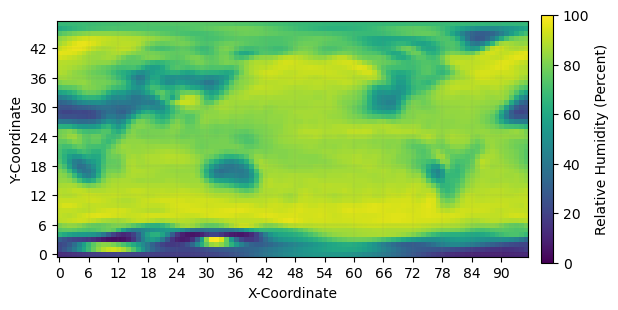

In [62]:

plt.imshow(avg_RH_every_gridpoint,origin='lower', vmin=0, vmax=100) # origin lower fixed it
plt.colorbar(orientation='vertical', fraction=0.025, pad=0.025, label = 'Relative Humidity (Percent)')
plt.grid(color='grey', linestyle='--', linewidth=.1)
plt.xlabel('X-Coordinate')
plt.xticks(range(0,96,6))
plt.yticks(range(0,48,6))
plt.ylabel('Y-Coordinate')
plt.show()

In [66]:
48*96

4608